# Детекција на аномалии

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.io import loadmat 
from scipy import stats   

from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import time

import pandas as pd
import seaborn as sns

## Потребни функции за моделирање на гаусова распределба и избирање на горна граница на густина на веројатност

In [324]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

def select_threshold(pval, yval):  # calculate the threshold and the f1-score 
    # Initialize nominal values:
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    # Initialize step size for 1000 steps across all possible probability values:
    step = (pval.max() - pval.min()) / 1000
    # Epsilon will take all the steps. For each epsilon:
    for epsilon in np.arange(pval.min(), pval.max(), step):
        # Preds are predictions - 1 if the probability is lower than epsilon (anomaly), 0 otherwise.
        # This is done for all features separately, not by multiplying them like in the lesson.
        preds = pval < epsilon

        # True positives (preds says it is an anomaly, and yval confirms):
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        # False positives (preds says it is an anomaly, but yval actualy isn't):
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        # False negatives (preds says it isn't an anomaly, but yval actualy is): 
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)

        precision = tp / (tp + fp) if tp + fp > 0 else 0                             # calculate precision
        recall = tp / (tp + fn) if tp + fn > 0 else 0                                  # calculate recall 
        f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0    # calucate f1

        if f1 > best_f1:                # If it is the best score so far:
            best_f1 = f1                # store this score as the best one
            best_epsilon = epsilon      # store this epsilon as the best one

    return best_epsilon, best_f1        # return the best threshold and score

## Вчитување на податоци

In [325]:
# Load and plot testing data:
data = loadmat('ex8data1.mat')  
print('Columns: ', list(data)[-3:])

Columns:  ['X', 'Xval', 'yval']


In [326]:
# Load training and validation data:
X = data['X']  
Xval = data['Xval']  
yval = data['yval'].flatten().astype(np.bool)
print('Shape of training data: ', X.shape)
print('Shape of validation data: ', Xval.shape)

Shape of training data:  (307, 2)
Shape of validation data:  (307, 2)


## Визуелизација на множеството за тренирање

(2.39141258073119, 28.691569810513457)

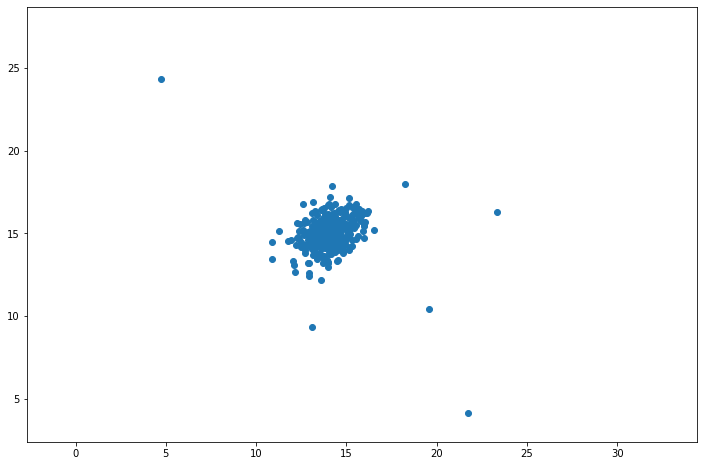

In [327]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1])
plt.xlim([min(Xval[:, 0]) - 3, 1.1*max(Xval[:, 0]) + 3])
plt.ylim([min(Xval[:, 1]) - 3, 1.1*max(Xval[:, 1]) + 3])

## Визуелизација на множеството за валидација

(2.39141258073119, 28.691569810513457)

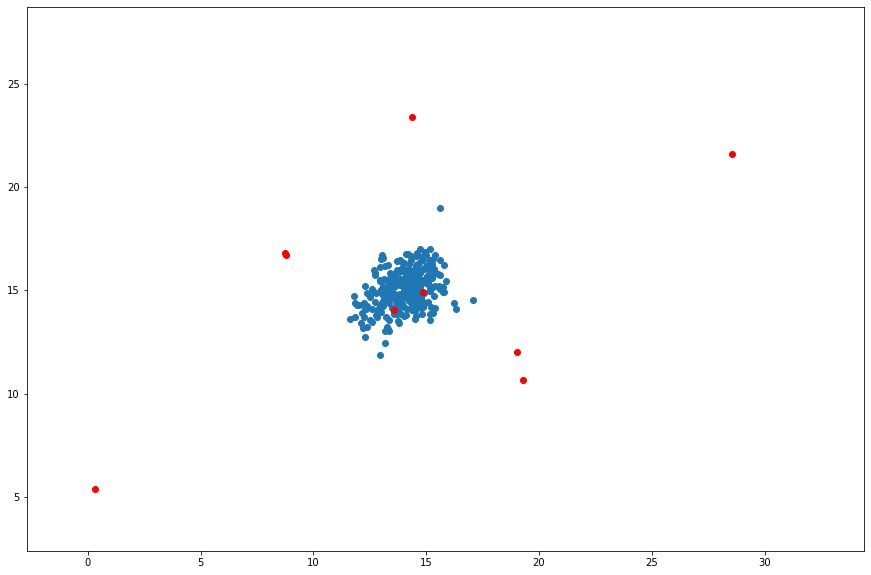

In [342]:
plt.figure(figsize=(15, 10))
plt.scatter(Xval[yval == 0, 0], Xval[yval == 0, 1])
plt.scatter(Xval[yval, 0], Xval[yval, 1], c='r')
plt.xlim([min(Xval[:, 0]) - 3, 1.1*max(Xval[:, 0]) + 3])
plt.ylim([min(Xval[:, 1]) - 3, 1.1*max(Xval[:, 1]) + 3])

## Пресметка на средна вредност и варијанса на секоја од карактеристиките

In [343]:
mu, sigma = estimate_gaussian(X)
print(f'mu: {mu}\nsigma: {sigma}')

mu: [ 0.03308389 -0.11371271]
sigma: [8.29761791 8.56606456]


## Наоѓање на густините на веројатност според моделираните распределби

In [344]:
p1 = stats.norm(mu[0], sigma[0]).pdf(Xval[:, 0])
p2 = stats.norm(mu[1], sigma[1]).pdf(Xval[:, 1])
p = p1*p2

## Наоѓање на горна граница на густина на веројатност

In [331]:
epsilon, f1 = select_threshold(p, yval)  
print ('Best epsilon is: ', epsilon, '\nBest f1 score is: ', f1)

predictions = p < epsilon
print ('Number of outliers: ', np.sum(predictions))

Best epsilon is:  0.00045713740891134883 
Best f1 score is:  0.8750000000000001
Number of outliers:  7


## Визуелизација на најдените аномалии со помош на алгоритмот

(2.39141258073119, 28.691569810513457)

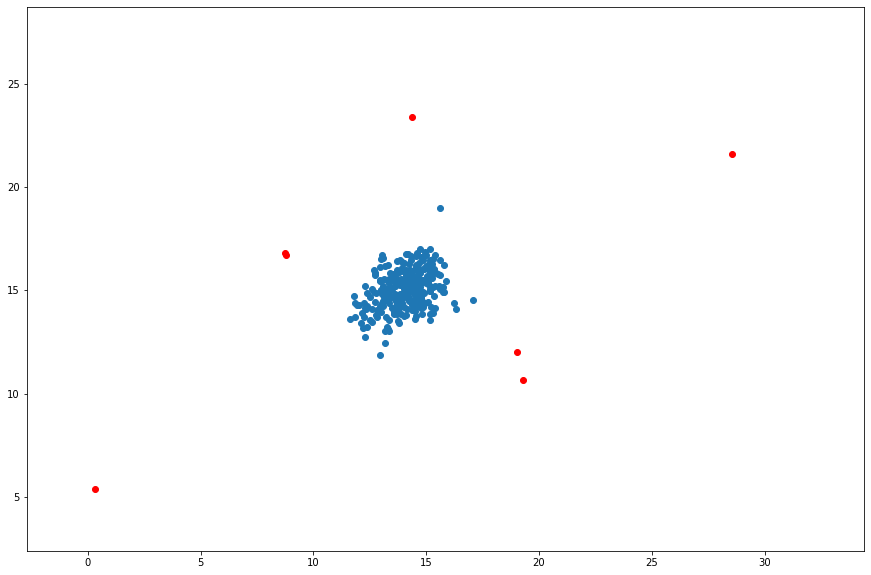

In [346]:
plt.figure(figsize=(15, 10))
plt.scatter(Xval[predictions == 0, 0], Xval[predictions == 0, 1])
plt.scatter(Xval[predictions, 0], Xval[predictions, 1], c='r')
plt.xlim([min(Xval[:, 0]) - 3, 1.1*max(Xval[:, 0]) + 3])
plt.ylim([min(Xval[:, 1]) - 3, 1.1*max(Xval[:, 1]) + 3])

## Детекција на аномалии со помош на повеќевеличинска гаусова распределба и Isolation Forest

In [347]:
n_samples = 300
outliers_fraction = 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [348]:
# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0], 
            make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0], 
            make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3], **blobs_params)[0],
            4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] - np.array([0.5, 0.25])), 
            14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5), 
            4. * make_circles(n_samples, noise=0.05, factor=0.99999)[0]]

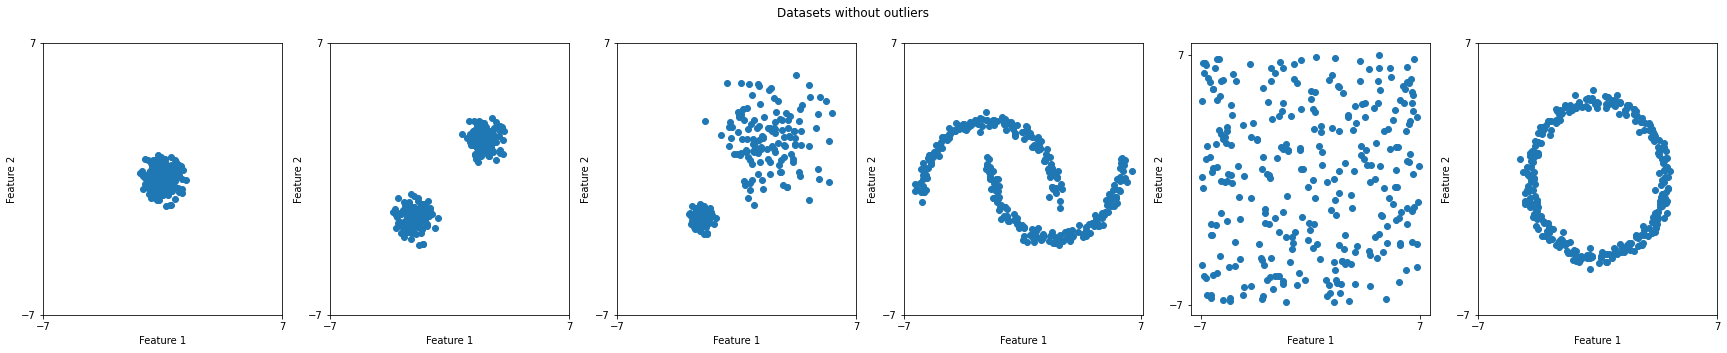

In [349]:
plt.figure(figsize=(30, 5))
plt.suptitle('Datasets without outliers')

for i, dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), i + 1)
    plt.scatter(dataset[:, 0], dataset[:, 1])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xticks([-7, 7])
    plt.yticks([-7, 7])


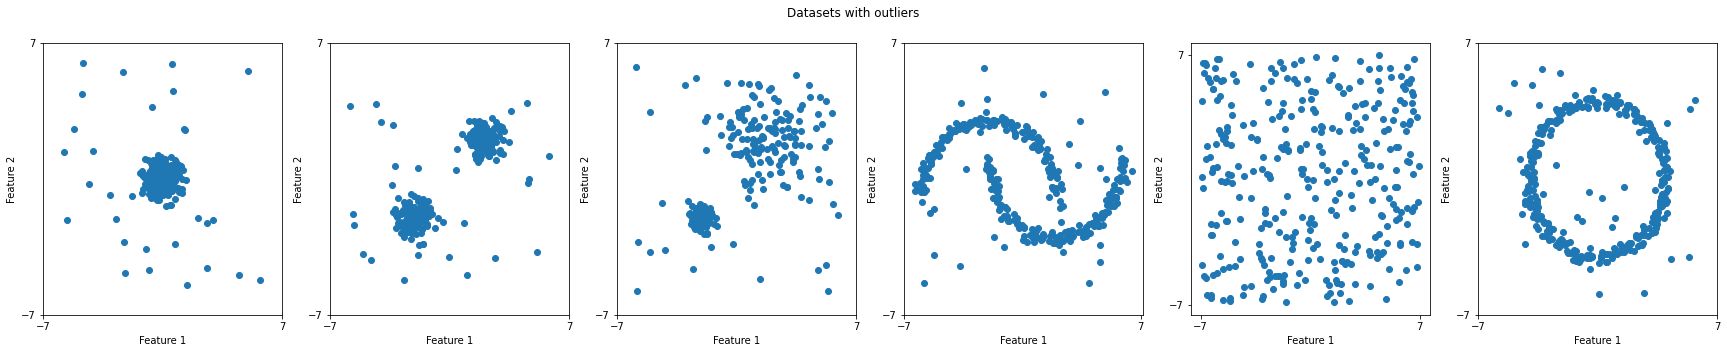

In [350]:
# Add outliers
plt.figure(figsize=(30, 5))
plt.suptitle('Datasets with outliers')
rng = np.random.RandomState()
for i, dataset in enumerate(datasets):
    dataset= np.concatenate([datasets[i], rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
    plt.subplot(1, len(datasets), i + 1)
    plt. scatter(dataset[:, 0], dataset[:, 1])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xticks([-7, 7])
    plt.yticks([-7, 7])

In [351]:
anomaly_algorithms = {'EllipticEnvelope': EllipticEnvelope(contamination=outliers_fraction), 
                      'IsolationForest': IsolationForest(contamination=outliers_fraction, random_state=rng)}

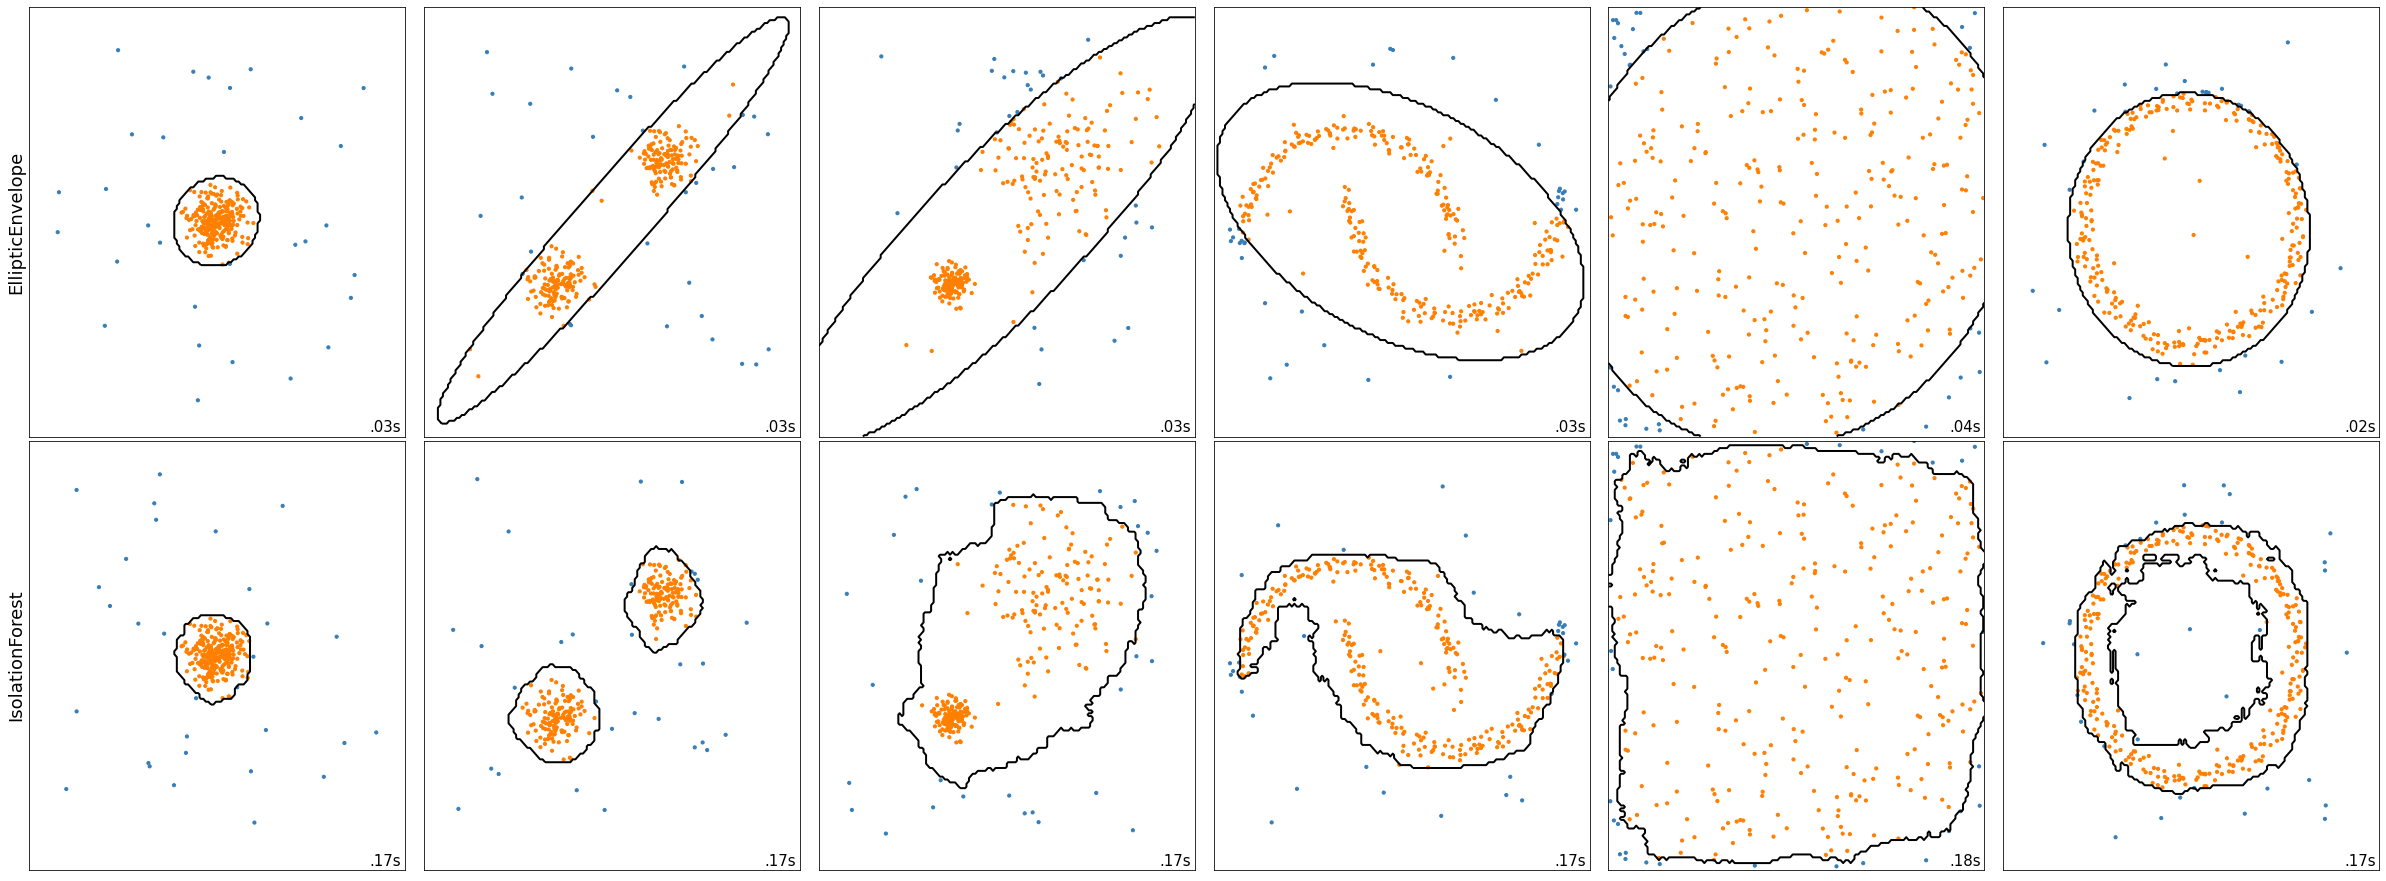

In [352]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 30, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1



for name, algorithm in anomaly_algorithms.items():
    for i_dataset, X in enumerate(datasets):
        # Add outliers
        X = np.concatenate([X, rng.uniform(low=-6, high=6,
                           size=(n_outliers, 2))], axis=0)
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(anomaly_algorithms), len(datasets), plot_num)

        if i_dataset == 0:
            plt.ylabel(name, size=18)

        y_pred = algorithm.predict(X)
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])
        
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
            
        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Детекција на аномалии во работата на лагери

Ова податочно множество е генерирано од NSF I/UCR [Центар за интелигентно одржување на системи](www.imscenter.net).

Податоците се добиени од тест машина на која се монтирани четири лагери на осовина. Осовината е придвижувана од електромотор спрегната со каиш и таа врти со константна ротациона брзина од 2000RPM. Осовината е изложена на постојан товар од 2700kg преку механизам на пружина. Лагерите се производство на фирмата Rexnord од тип ZA-2115 и тие се поставени како што е прикажано во долната слика.

![Приказ на машината](IMSBearingData.jpg)

Акцелерометри со висока сензитивност Quarts ICP се монтирани на секое куќиште од лагерите. Конкретно, распределени се по два акцелерометри за секој лагер по x и y оска во податочно множество 1, еден акцелерометар за секој лагер во податочно множество 2 и 3. Поставеноста на сензорите е исто така прикажана во сликата. Сите механички потфрлувања на лагерите се настанати после надминување на предвидениот живот на работа кој што е над 100 милиони револуции. За повеќе податоци прочитајте го „Readme Document for IMS Bearing Data.pdf".

In [3]:
import wget
import os
import libarchive
import seaborn as sns

## Симнување на податоците
Податоците се состојат од повеќе множества и вкупната големина е 1GB. Откако ќе се симне датотеката можете да ги избришете оние податочни множества кои не се потребни(под. множество 1 и 3).

In [376]:
os.mkdir('BearingDataSet')
wget.download('https://ti.arc.nasa.gov/c/3/', 'BearingDataSet\IMS-Bearing-Data.7z')

  0% [                                                                    ]    2621440 / 1075320408

KeyboardInterrupt: 

## Отпакување на податоците
Отпакувајте ги податоците во соодветната папка.

## Вчитување на податоците
Мерењата од акцелерометрите се со фреквенција од 20KHz и една датотека содржи мерења во текот на десет минутна временска рамка. Ние ќе направиме агрегација на една временска рамка и ќе ја претставиме како една податочка точка така што ќе ја пресметаме средната вредност на забрзувањата за секој лагер.

In [4]:
data_dir = 'BearingDataSet\\2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing_1','Bearing_2','Bearing_3','Bearing_4']

In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 2004.02.12.10.32.39 to 2004.02.19.06.22.39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing_1  984 non-null    float64
 1   Bearing_2  984 non-null    float64
 2   Bearing_3  984 non-null    float64
 3   Bearing_4  984 non-null    float64
dtypes: float64(4)
memory usage: 38.4+ KB


In [6]:
merged_data.describe()

,Bearing_1,Bearing_2,Bearing_3,Bearing_4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


In [7]:
merged_data.head()

,Bearing_1,Bearing_2,Bearing_3,Bearing_4
2004.02.12.10.32.39,0.058333,0.071832,0.083242,0.043067
2004.02.12.10.42.39,0.058995,0.074006,0.084435,0.044541
2004.02.12.10.52.39,0.060236,0.074227,0.083926,0.044443
2004.02.12.11.02.39,0.061455,0.073844,0.084457,0.045081
2004.02.12.11.12.39,0.061361,0.075609,0.082837,0.045118


In [8]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing_1,Bearing_2,Bearing_3,Bearing_4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


## Истражување и визуелизација на податочното множество

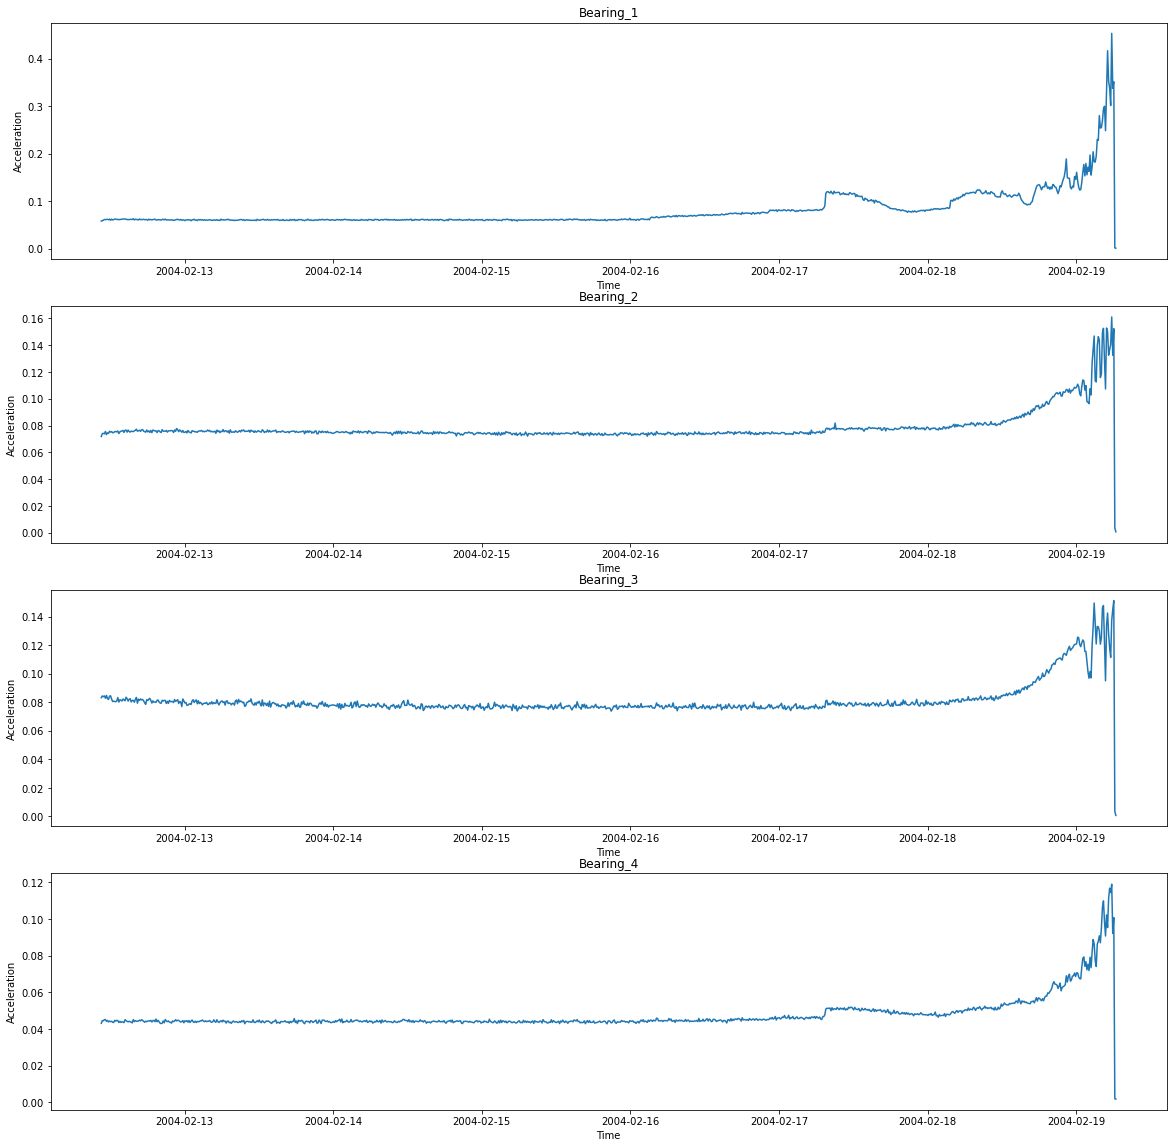

In [9]:
plt.figure(figsize=(20, 20))
for i, column in enumerate(merged_data.columns):
    plt.subplot(len(merged_data.columns), 1, i + 1)
    plt.plot(merged_data[f'Bearing_{i + 1}'])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.title(column)

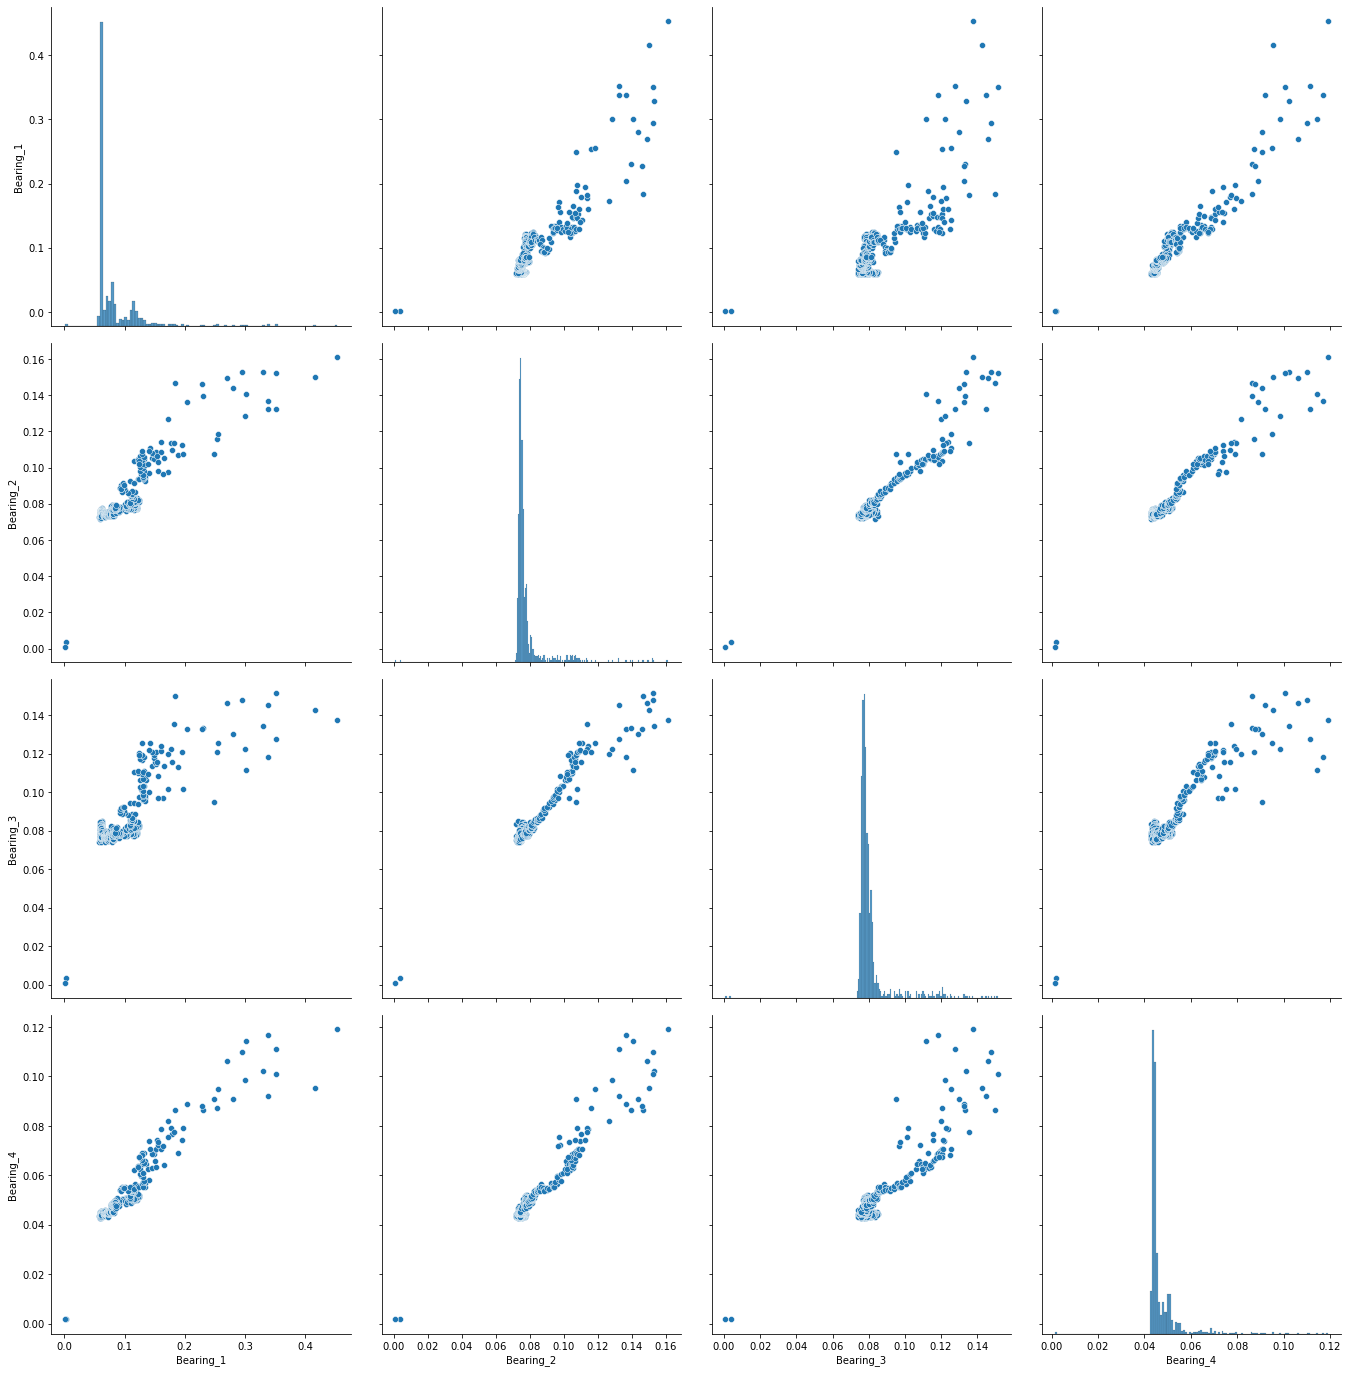

In [10]:
g = sns.pairplot(data=merged_data)
g.fig.set_size_inches(20, 20)

## Поделба на податочното множество
Ќе го поделиме множество на множество за тренирање кое што ја содржи нормалната работа на лагерите и тест множество кое ја содржи нормалната работа на лагерите па се' до моментот на расипување.

<AxesSubplot:>

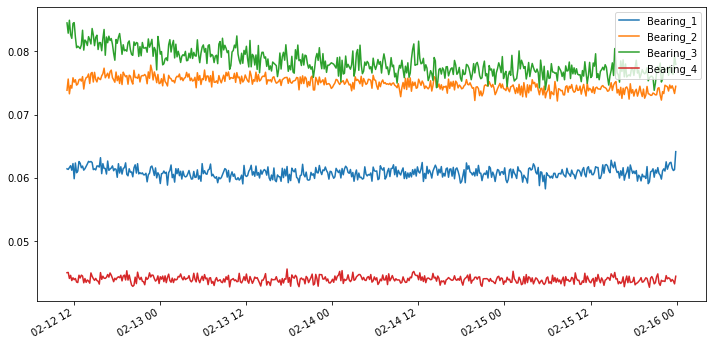

In [133]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-15 23:52:39'].copy()
dataset_test = merged_data['2004-02-15 23:52:39':].copy()
dataset_train.plot(figsize = (12,6))

<AxesSubplot:>

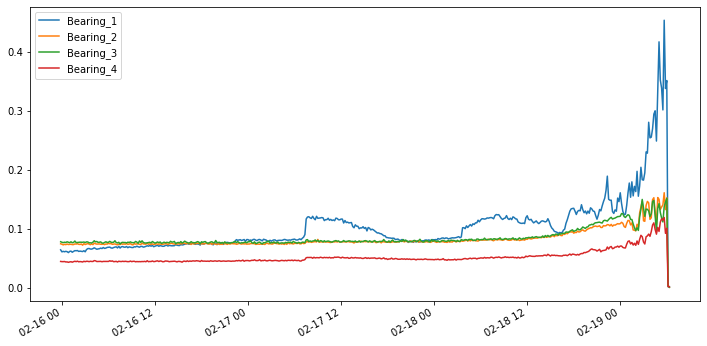

In [134]:
dataset_test.plot(figsize = (12,6))

<AxesSubplot:>

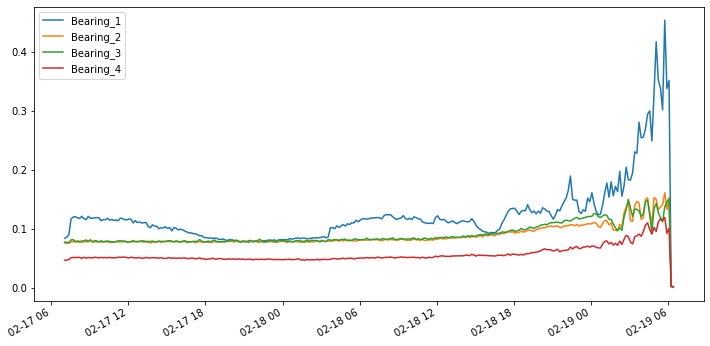

In [135]:
dataset_test['2004-02-17-07':].plot(figsize = (12,6))

## Развој на модел

In [136]:
model = EllipticEnvelope(contamination=0, random_state=1)

In [137]:
model.fit(dataset_train)

EllipticEnvelope(contamination=0, random_state=1)

In [138]:
prediction_function = model.decision_function(dataset_test)

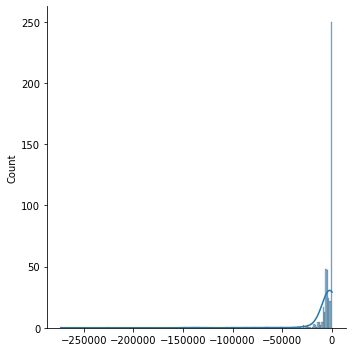

In [139]:
sns.displot(prediction_function, kde=True)

(-100000.0, 1000.0)

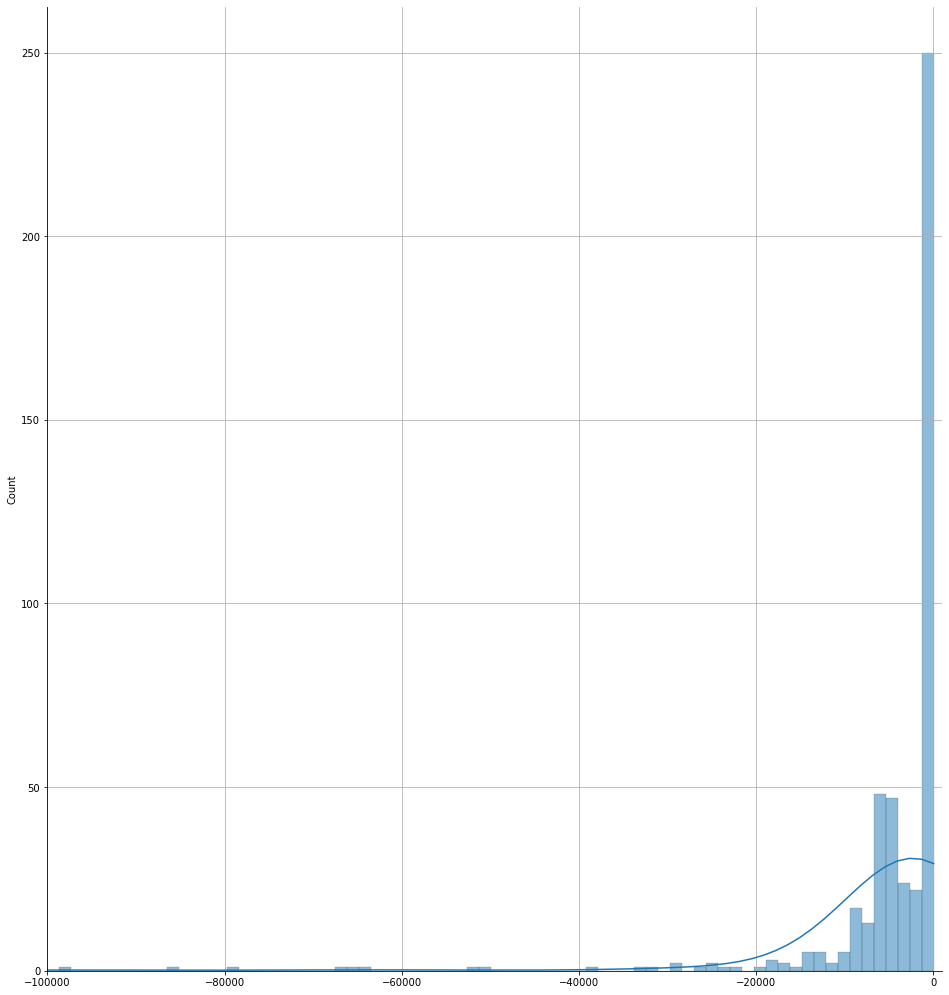

In [140]:
g = sns.displot(data=prediction_function, kde=True)
g.fig.set_size_inches(15, 15)
plt.grid()
plt.xlim([-100000, 1000])

In [149]:
prediction = prediction_function < -40000

In [150]:
dataset_test['Anomaly'] = prediction.astype('uint8')

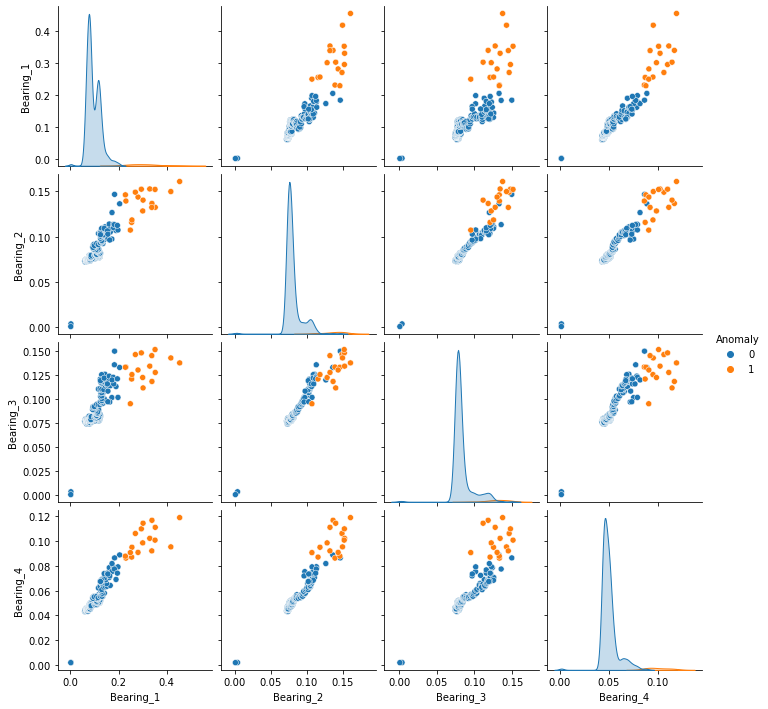

In [151]:
sns.pairplot(data=dataset_test, hue='Anomaly')

<AxesSubplot:>

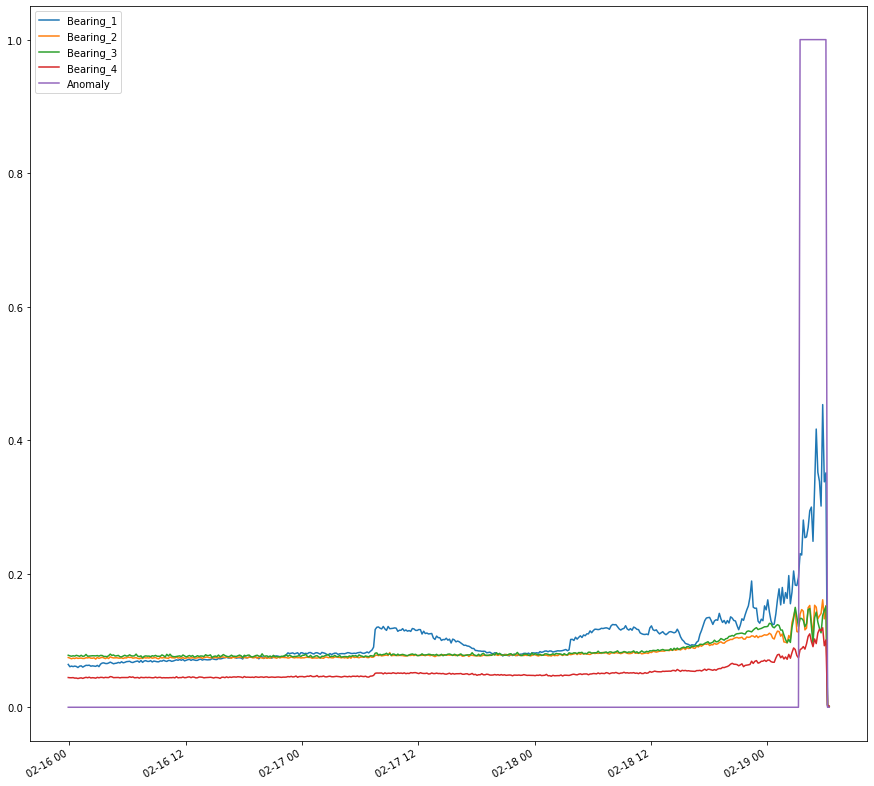

In [152]:
dataset_test.plot(figsize=(15, 15))

In [161]:
print('Дефектот се детектира 45 часа пред да настане:', dataset_test[dataset_test['Anomaly'] == 1].index[0] - dataset_test.index[-1])

Дефектот се детектира 45 часа пред да настане: -1 days +21:00:00
